# <b>TIMESERIES CLUSTERING</b>

In this notebook we want to show:



- Hierarchical Clustering for timeseries
- Knee & Elbow analysis
- Correlation Heatmap

First we load all the necessary libraries and we load the .csv files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
sys.path.append("../")

from preprocessing.preprocessing import convert_date 

train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

Here we define a function to convert the date form.

In [2]:
df = pd.concat([train, test],sort=False)
df = convert_date(df)
df = df.sort_values(['sku','Date'])

# <b>Plot</b>

Separate train and test dataset.

In [3]:
train = df[~df.target.isna()]
test = df[df.target.isna()]

## Plotting some data

Here we visualize the timeseries, plotting them. 

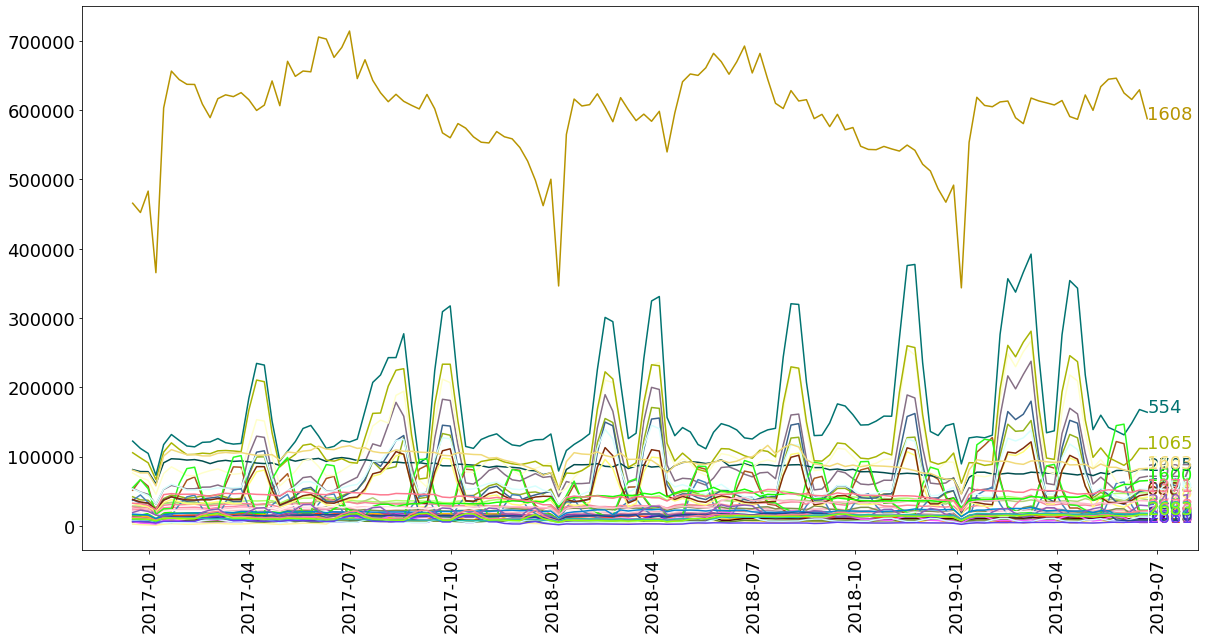

In [5]:
train = train.reset_index()

mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(train.sku)):
    plt.plot(train[train.sku==s].Date, train[train.sku==s]['sales w-1'],  color=mycolors[i])
    last_x, last_y = train[train.sku==s].Date.values[-1], train[train.sku==s]['sales w-1'].values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

# <b>Hierarchical Clustering</b>

In this section we perform clustering, more precisely the hierarchical clustering. The intention is to group together the most correlated timeseries and to see their progress.

First, we load all the libraries.

In [6]:
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats


Then we group the timeseries by sku and we compute the distance matrix for the hierarchical clustering using the <i>linkage</i> function. 

The distance measure used for the clustering is the <i>correlation</i> between each pairs of timeseries.


In [7]:
series1=[]
ix=[]
for i, s in enumerate(set(train.sku)):
    ix.append(s)
    series1.append(((train[train.sku==s]['sales w-1']).dropna().values))
series1=np.asarray(series1)
z1= linkage(series1,'single',metric='correlation')



Then we plot the resulting dendogram.

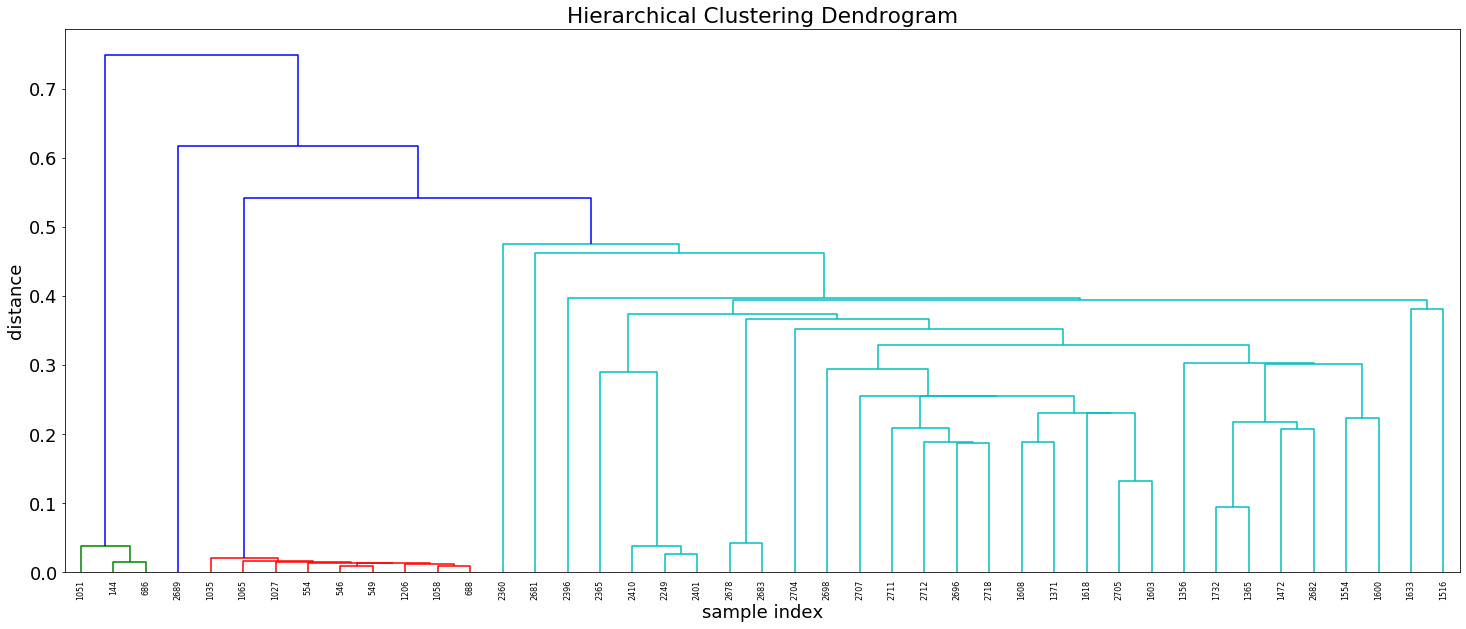

In [8]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(z1, 
    leaf_rotation=90.,  
    leaf_font_size=8.,  
    labels=ix
)
plt.show()

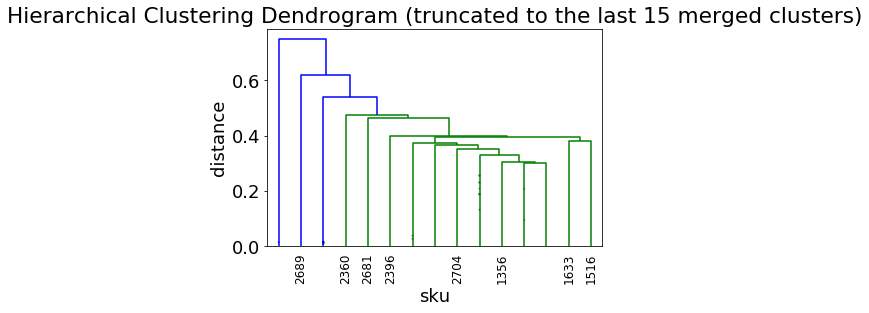

In [9]:
plt.title('Hierarchical Clustering Dendrogram (truncated to the last 15 merged clusters)')
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.xlabel('sku')
plt.ylabel('distance')
dendrogram(
    z1,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=15,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    labels=ix
)
plt.show()

# <b>Knee & Elbow Analysis</b>

Since the resulting dendogram doesn't help us too much to understand the best cut level and so the best number of clusters, we use the <i>Knee & Elbow</i> analysis.

So in the following section of code we compute the WSS and the BSS to see respectively how the objects are closely related in the cluster and how well separated is a cluster from the other clusters.

In [9]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(z1, k, criterion='maxclust')
    centroids = [np.mean(series1[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(series1, centroids, 'correlation')
    D = cdist(series1, centroids,'correlation')

    d = np.min(D,axis=1)

    avgWithinSS = sum(d)/series1.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(series1,metric='correlation')**2)/series1.shape[0]
    
    bss = tss-wss
    
    wss_values += [wss]
    bss_values += [bss]

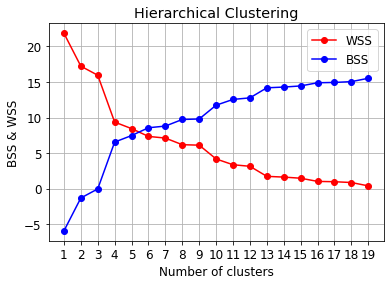

In [10]:
fig = plt.figure()
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

We plot the result and we can see that at 4 there is a drop in the plot.
There is an evident elbow at 4 so we put our evidence on what happens with 4 clusters. 

Using the <i>fcluster</i> function we found the labels of the 4 clusters and we retrieve the corresponding sku, creating a small dataframe.

In [11]:
label_corr=fcluster(z1,4,criterion='maxclust') #Cluster with "correlation distance measure"
sku=list((set(train.sku)))

data={'Label': label_corr,
     'Sku':sku}
df_cluster=pd.DataFrame(data, columns=['Label','Sku'])



In [12]:
#Timeseries of 1st cluster
cluster1=df_cluster[df_cluster.Label==1].Sku
cluster1=np.asarray(cluster1)
#2 cluster
cluster2=df_cluster[df_cluster.Label==2].Sku
cluster2=np.asarray(cluster2)
#3 cluster
cluster3=df_cluster[df_cluster.Label==3].Sku
cluster3=np.asarray(cluster3)
#4 cluster
cluster4=df_cluster[df_cluster.Label==4].Sku
cluster4=np.asarray(cluster4)

cluster=[cluster1,cluster2,cluster3,cluster4]


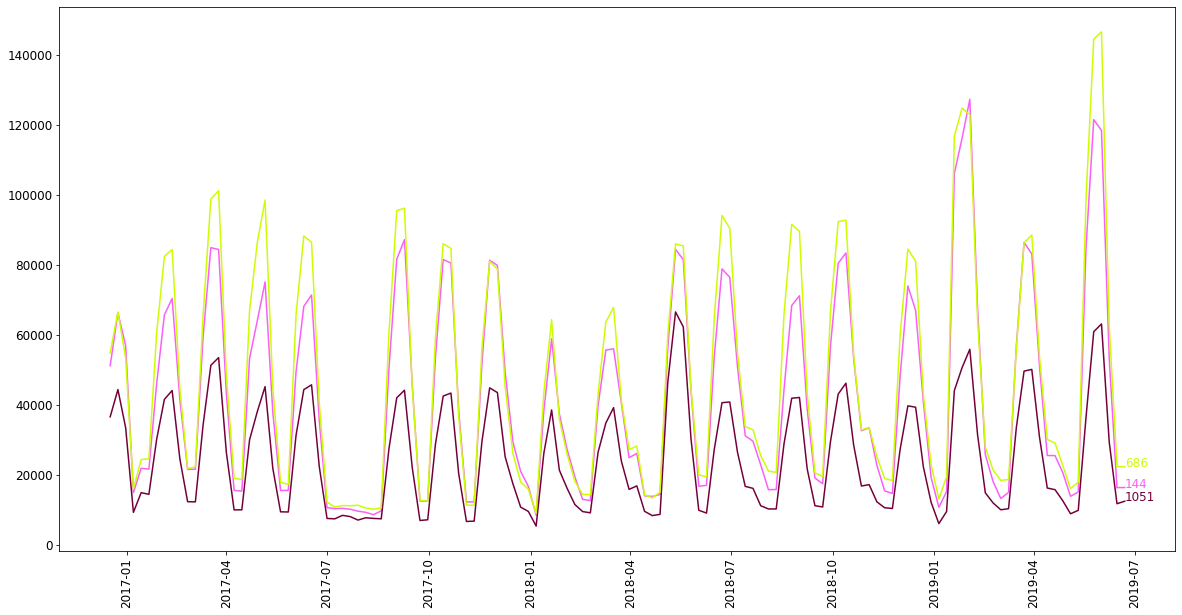

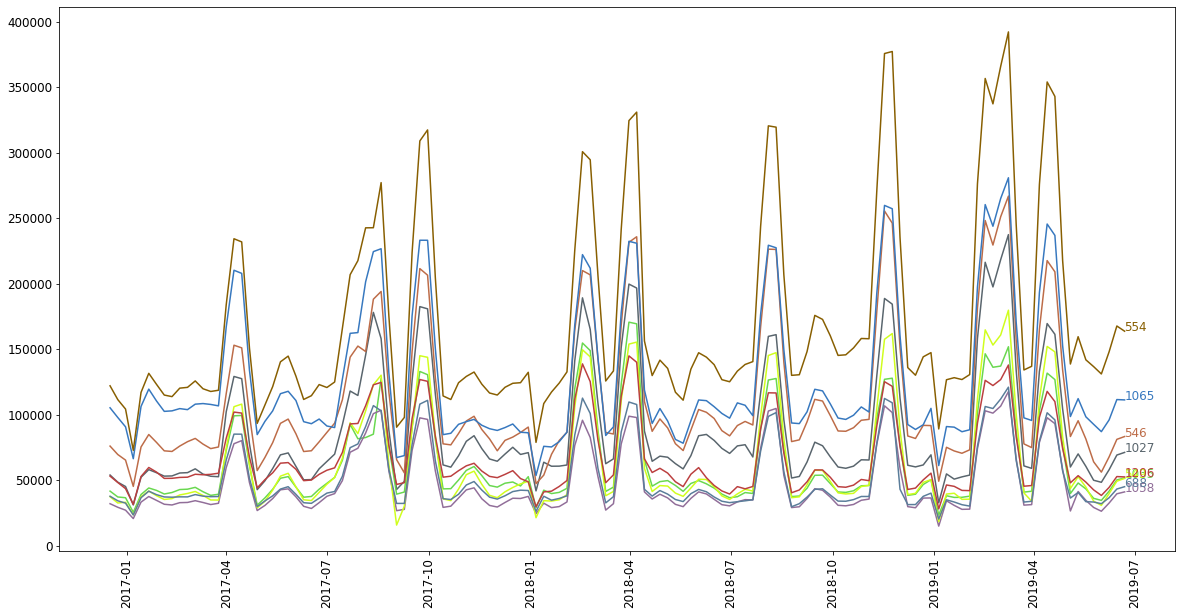

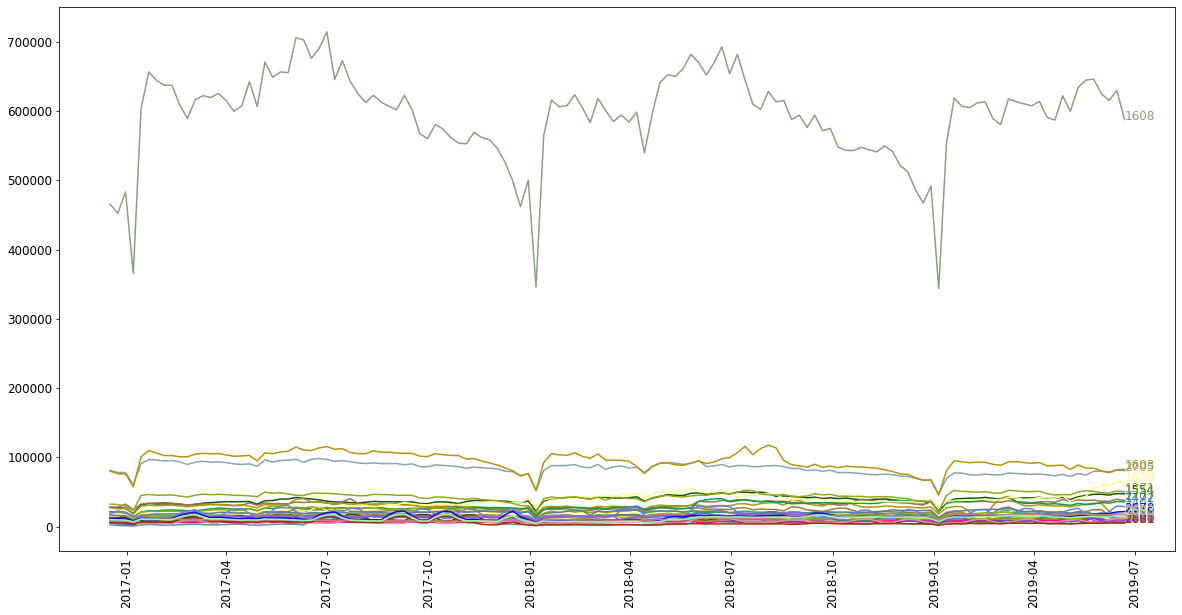

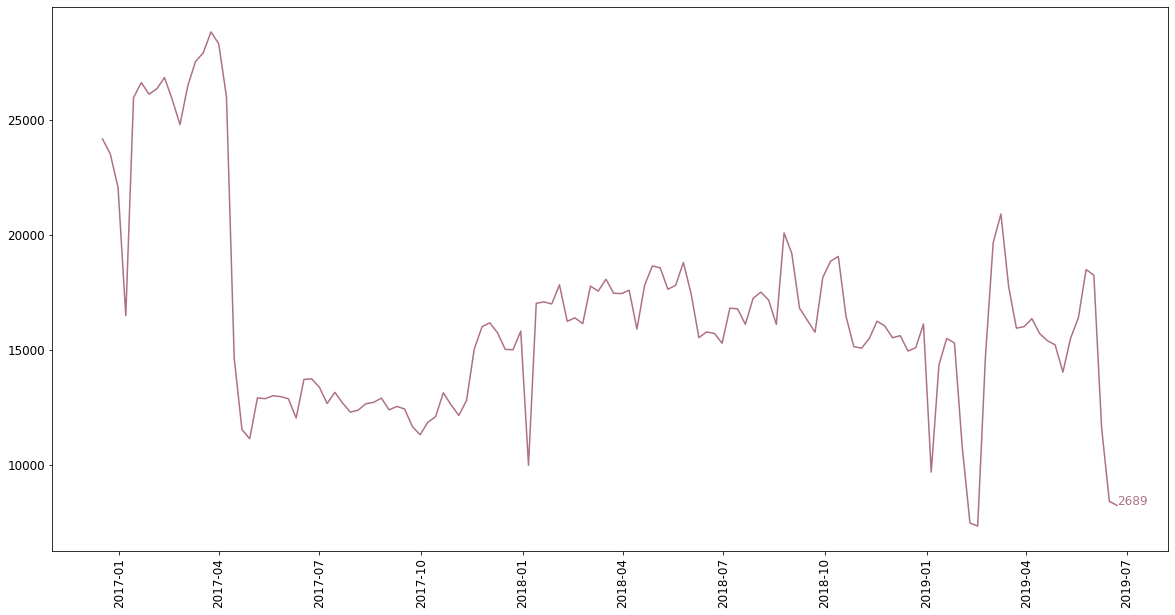

In [13]:
for j in cluster:
    
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    for i in range(len(j)):
        plt.plot(train[train.sku==j[i]].Date, train[train.sku==j[i]]['sales w-1'],  color=mycolors[i])
        last_x, last_y = train[train.sku==j[i]].Date.values[-1], train[train.sku==j[i]]['sales w-1'].values[-1]
        plt.text(last_x, last_y, str(j[i]), color=mycolors[i])


We can notice that the last cluster is composed only by one element, so it might be labeled as outlier. 


# <b>Correlation Heatmap</b>

Then, we plot the correlation heatmap for the first two clusters (they will be used for training the models) to show that the timeseries inside the clusters are highly correlated.

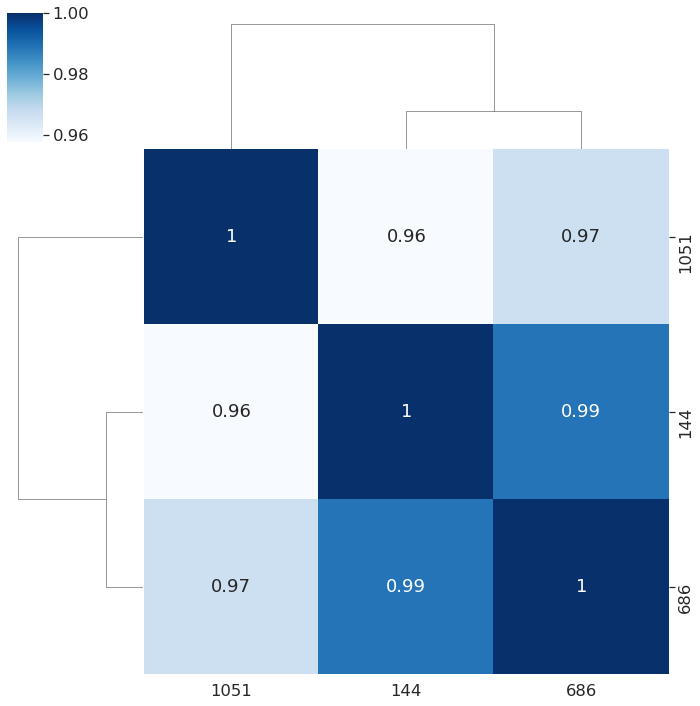

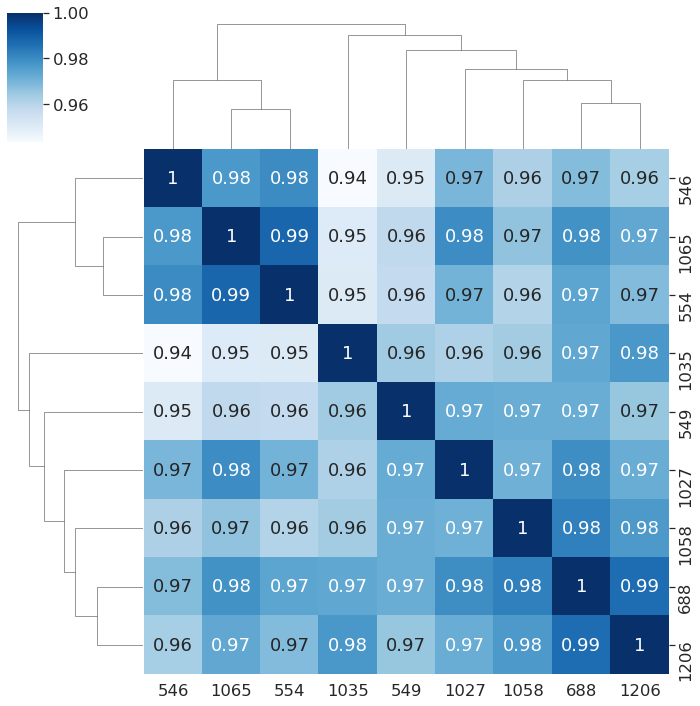

In [14]:

di={}

for i in cluster1:
    di.update({i:np.asarray((train[train.sku==i].target))})
df_clu1=pd.DataFrame(di).pct_change().dropna()

corr1=df_clu1.corr()
sns.set(font_scale=1.5)
sns.clustermap(corr1, cmap="Blues", annot=True);

di2={}
for i in cluster2:
    di2.update({i:np.asarray((train[train.sku==i].target))})
df_clu2=pd.DataFrame(di2).pct_change().dropna()

corr2=df_clu2.corr()
sns.set(font_scale=1.5)
sns.clustermap(corr2, cmap="Blues", annot=True);



The correlation heatmap of the third and fourth cluster are not showed, since the fourth cluster is composed only by one 
element and the third contains too much timeseries, so it would result in a very big heatmap and it couldn't be well visualized.